# AUTHOR: Li Weihang

# NUM: 2101212316

In [79]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from scipy.stats.mstats import winsorize
from sklearn.linear_model import Lasso,LassoCV,LassoLarsCV
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import lightgbm as lgb
from sklearn.tree import DecisionTreeClassifier,plot_tree

## 1. Data reader

In [11]:
train = pd.read_csv('./data/cs-training.csv',index_col=0)
test = pd.read_csv('./data/cs-test.csv',index_col=0)
sample = pd.read_csv('./data/sampleEntry.csv',index_col=0)
features = train.columns[1:]
label = 'SeriousDlqin2yrs'

In [12]:
## Merge train and test data to further data process
train['train_or_test'] = 1
test['train_or_test'] = 0
all_data = pd.concat([train,test])
all_data.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,train_or_test
1,1.0,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0,1
2,0.0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0,1
3,0.0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0,1
4,0.0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0,1
5,0.0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0,1


In [13]:
## fill NA values ,use forward filling
all_data.fillna(method='ffill',inplace=True)
all_data.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,train_or_test
1,1.0,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0,1
2,0.0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0,1
3,0.0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0,1
4,0.0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0,1
5,0.0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0,1


In [14]:
## Make sure there is no NA value in all_data
np.sum(all_data.isna())

SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
train_or_test                           0
dtype: int64

## 2. Drop outlier and make normalization

In [15]:
for col in features:
    all_data.loc[:,col] = winsorize(all_data.loc[:,col],limits=[0.005,0.005])
all_data.loc[:,features] = (all_data.loc[:,features] - all_data.loc[:,features].mean()) / all_data.loc[:,features].std()

In [16]:
all_data.loc[:,'DebtRatio'] = winsorize(all_data.loc[:,'DebtRatio'],limits=[0.005,0.001])

In [17]:
all_data['DebtRatio'].describe()

count    2.515030e+05
mean    -2.440961e-17
std      1.000000e+00
min     -3.395364e-01
25%     -3.393539e-01
50%     -3.391537e-01
75%     -3.386344e-01
max      6.169604e+00
Name: DebtRatio, dtype: float64

## 3. Feature Analysis

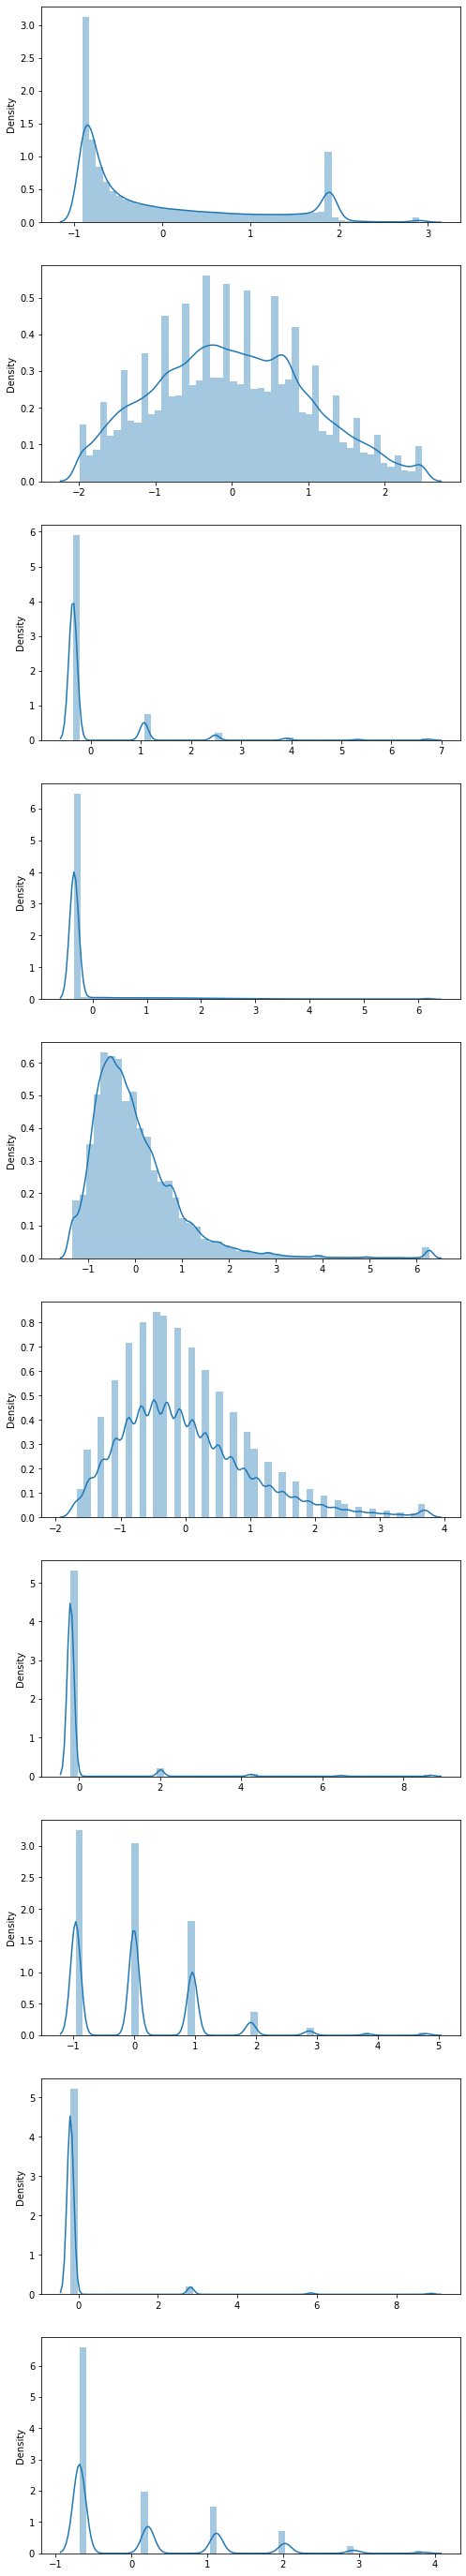

In [18]:
n = len(features)
fig = plt.figure(figsize=(8,5*n))
for i,col in enumerate(features):
    fig.add_subplot(n,1,i+1)
    sns.distplot(all_data[col].values)

## 4. PCA method

In [21]:
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV 
pca = PCA(n_components = 3)
pca.fit(all_data[features])

PCA(n_components=3)

In [29]:
data_pca = pd.DataFrame(pca.transform(all_data[features]),columns=['pca1','pca2','pca3'])
data_pca['train_or_test'] = all_data['train_or_test'].values
data_pca[label] = all_data[label].values
data_pca

,pca1,pca2,pca3,train_or_test,SeriousDlqin2yrs
0,0.022619,4.441500,-0.876277,1,1.0
1,1.354704,-1.293002,-1.131562,1,0.0
2,2.635859,-0.979755,0.189809,1,0.0
3,0.533472,-1.551058,-0.602958,1,0.0
4,-0.102607,2.481366,-1.081749,1,0.0
...,...,...,...,...,...
251498,0.780667,-1.683486,-0.777827,0,0.0
251499,2.318083,2.732466,-2.091395,0,0.0
251500,-0.322092,-0.335179,-1.177617,0,0.0
251501,0.485603,2.228912,0.573868,0,0.0


## 5. Grid Search Method for LightGBM 

### 5.1 data set

In [31]:
new_train = data_pca.loc[data_pca['train_or_test']==1].reset_index().drop('index',axis=1)
new_train.head()

,pca1,pca2,pca3,train_or_test,SeriousDlqin2yrs
0,0.022619,4.441500,-0.876277,1,1.0
1,1.354704,-1.293002,-1.131562,1,0.0
2,2.635859,-0.979755,0.189809,1,0.0
3,0.533472,-1.551058,-0.602958,1,0.0
4,-0.102607,2.481366,-1.081749,1,0.0


### 5.2 LGBM基本参数设置

In [59]:
 params0 = {
     'objective': 'binary',
     'metric': 'binary_logloss,auc',
     'max_depth': 6,
     'num_leaves': 40,
     'learning_rate': 0.1,
     #'feature_fraction': 1,
     'min_child_samples': 21,
     'min_child_weight': 0.001,
     #'bagging_fraction': 1,
     #'bagging_freq': 0,
     'reg_alpha': 0.001,
     'reg_lambda': 8,
     'cat_smooth': 0,
     'num_iterations': 200,
     'verbose':-1,
}             

### 5.3 调整max_depth 和 num_leaves

In [63]:
parameters = {
    'max_depth': [4,6,8],
    'num_leaves': [20,30,40],
}

lgbm = lgb.LGBMClassifier(**params0)
gsearch = GridSearchCV(lgbm, param_grid=parameters, scoring='roc_auc', cv=5)
gsearch.fit(new_train[['pca1','pca2','pca3']].values, new_train[label].values)
print('参数的最佳取值:{0}'.format(gsearch.best_params_))
print('最佳模型得分:{0}'.format(gsearch.best_score_))
print(gsearch.cv_results_['mean_test_score'])
print(gsearch.cv_results_['params'])

参数的最佳取值:{'max_depth': 4, 'num_leaves': 20}
最佳模型得分:0.8530084543364786
[0.85300845 0.85300845 0.85300845 0.85266176 0.85162234 0.85137974
 0.85258689 0.85180301 0.85092246]
[{'max_depth': 4, 'num_leaves': 20}, {'max_depth': 4, 'num_leaves': 30}, {'max_depth': 4, 'num_leaves': 40}, {'max_depth': 6, 'num_leaves': 20}, {'max_depth': 6, 'num_leaves': 30}, {'max_depth': 6, 'num_leaves': 40}, {'max_depth': 8, 'num_leaves': 20}, {'max_depth': 8, 'num_leaves': 30}, {'max_depth': 8, 'num_leaves': 40}]


### 5.4 调整min_child_samples 和 min_child_weight

In [64]:
parameters = {
    'min_child_samples': [18,19,20,21,22],
    'min_child_weight': [0.001,0.002],
}

lgbm = lgb.LGBMClassifier(**params0)
gsearch = GridSearchCV(lgbm, param_grid=parameters, scoring='roc_auc', cv=5)
gsearch.fit(new_train[['pca1','pca2','pca3']].values, new_train[label].values)
print('参数的最佳取值:{0}'.format(gsearch.best_params_))
print('最佳模型得分:{0}'.format(gsearch.best_score_))
print(gsearch.cv_results_['mean_test_score'])
print(gsearch.cv_results_['params'])

参数的最佳取值:{'min_child_samples': 19, 'min_child_weight': 0.001}
最佳模型得分:0.8516622635051754
[0.85147317 0.85147317 0.85166226 0.85166226 0.85142316 0.85142316
 0.85137974 0.85137974 0.85106665 0.85106665]
[{'min_child_samples': 18, 'min_child_weight': 0.001}, {'min_child_samples': 18, 'min_child_weight': 0.002}, {'min_child_samples': 19, 'min_child_weight': 0.001}, {'min_child_samples': 19, 'min_child_weight': 0.002}, {'min_child_samples': 20, 'min_child_weight': 0.001}, {'min_child_samples': 20, 'min_child_weight': 0.002}, {'min_child_samples': 21, 'min_child_weight': 0.001}, {'min_child_samples': 21, 'min_child_weight': 0.002}, {'min_child_samples': 22, 'min_child_weight': 0.001}, {'min_child_samples': 22, 'min_child_weight': 0.002}]


### 5.5 调整 reg_alpha 和 reg_lambda

In [65]:
parameters = {
    'reg_alpha': [0,0.1,0.01,0.001],
    'reg_lambda': [2,5,8,10],
}

lgbm = lgb.LGBMClassifier(**params0)
gsearch = GridSearchCV(lgbm, param_grid=parameters, scoring='roc_auc', cv=5)
gsearch.fit(new_train[['pca1','pca2','pca3']].values, new_train[label].values)
print('参数的最佳取值:{0}'.format(gsearch.best_params_))
print('最佳模型得分:{0}'.format(gsearch.best_score_))
print(gsearch.cv_results_['mean_test_score'])
print(gsearch.cv_results_['params'])

参数的最佳取值:{'reg_alpha': 0.01, 'reg_lambda': 10}
最佳模型得分:0.851559379921782
[0.85054289 0.85103737 0.8514993  0.85139987 0.85055262 0.85122261
 0.8513842  0.85152254 0.85051369 0.8510503  0.85139603 0.85155938
 0.85022488 0.85105947 0.85137974 0.85150482]
[{'reg_alpha': 0, 'reg_lambda': 2}, {'reg_alpha': 0, 'reg_lambda': 5}, {'reg_alpha': 0, 'reg_lambda': 8}, {'reg_alpha': 0, 'reg_lambda': 10}, {'reg_alpha': 0.1, 'reg_lambda': 2}, {'reg_alpha': 0.1, 'reg_lambda': 5}, {'reg_alpha': 0.1, 'reg_lambda': 8}, {'reg_alpha': 0.1, 'reg_lambda': 10}, {'reg_alpha': 0.01, 'reg_lambda': 2}, {'reg_alpha': 0.01, 'reg_lambda': 5}, {'reg_alpha': 0.01, 'reg_lambda': 8}, {'reg_alpha': 0.01, 'reg_lambda': 10}, {'reg_alpha': 0.001, 'reg_lambda': 2}, {'reg_alpha': 0.001, 'reg_lambda': 5}, {'reg_alpha': 0.001, 'reg_lambda': 8}, {'reg_alpha': 0.001, 'reg_lambda': 10}]


### 5.6 调整 cat_smooth

In [66]:
parameters = {
     'cat_smooth': [0,10,20],
}
lgbm = lgb.LGBMClassifier(**params0)
gsearch = GridSearchCV(lgbm, param_grid=parameters, scoring='roc_auc', cv=5)
gsearch.fit(new_train[['pca1','pca2','pca3']].values, new_train[label].values)
print('参数的最佳取值:{0}'.format(gsearch.best_params_))
print('最佳模型得分:{0}'.format(gsearch.best_score_))
print(gsearch.cv_results_['mean_test_score'])
print(gsearch.cv_results_['params'])

参数的最佳取值:{'cat_smooth': 0}
最佳模型得分:0.8513797444798452
[0.85137974 0.85137974 0.85137974]
[{'cat_smooth': 0}, {'cat_smooth': 10}, {'cat_smooth': 20}]


## 5.7 得到最优的模型参数

In [68]:
best_params = {
     'objective': 'binary',
     'metric': 'binary_logloss,auc',
     'max_depth': 4,
     'num_leaves': 20,
     'learning_rate': 0.1,
     'min_child_samples': 18,
     'min_child_weight': 0.001,
     'reg_alpha': 0,
     'reg_lambda': 2,
     'cat_smooth': 0,
     'num_iterations': 200,
     'verbose':-1,
}    

## 6. LGBM五折交叉验证

In [70]:
new_train = data_pca.loc[data_pca['train_or_test']==1].reset_index().drop('index',axis=1)
kfolds = KFold(n_splits=5, shuffle=False)
best_features = ['pca1','pca2','pca3']
for i,(train_idx, val_idx) in enumerate(kfolds.split(new_train)):
    # Split train and valid
    train_x = new_train.loc[train_idx,best_features].values
    valid_x = new_train.loc[val_idx,best_features].values
    train_y = new_train.loc[train_idx,label].values
    valid_y = new_train.loc[val_idx,label].values
    
    dtrain = lgb.Dataset(train_x,train_y)
    dvalid = lgb.Dataset(valid_x,valid_y)
    # LGBM模型训练
    model = lgb.train(best_params, dtrain, valid_sets=[dtrain, dvalid], 
                      verbose_eval=20, early_stopping_rounds=100)

    # 对验证集进行预测
    valid_pred = model.predict(valid_x)
    score = roc_auc_score(valid_y, valid_pred)
    print(f'fold{i+1}: vaild AUC is :{round(score,3)}')

Training until validation scores don't improve for 100 rounds
[20]	training's binary_logloss: 0.184063	training's auc: 0.855001	valid_1's binary_logloss: 0.180721	valid_1's auc: 0.849778
[40]	training's binary_logloss: 0.181194	training's auc: 0.859176	valid_1's binary_logloss: 0.178872	valid_1's auc: 0.852081
[60]	training's binary_logloss: 0.180386	training's auc: 0.861054	valid_1's binary_logloss: 0.178751	valid_1's auc: 0.852476
[80]	training's binary_logloss: 0.179921	training's auc: 0.862222	valid_1's binary_logloss: 0.178787	valid_1's auc: 0.85222
[100]	training's binary_logloss: 0.179401	training's auc: 0.863508	valid_1's binary_logloss: 0.178825	valid_1's auc: 0.852131
[120]	training's binary_logloss: 0.178882	training's auc: 0.86482	valid_1's binary_logloss: 0.178877	valid_1's auc: 0.852122
[140]	training's binary_logloss: 0.17839	training's auc: 0.866127	valid_1's binary_logloss: 0.17888	valid_1's auc: 0.852126
[160]	training's binary_logloss: 0.177965	training's auc: 0.8671

## 6. Logistic Regression

In [75]:
new_train = data_pca.loc[data_pca['train_or_test']==1].reset_index().drop('index',axis=1)
kfolds = KFold(n_splits=5, shuffle=False)
best_features = ['pca1','pca2','pca3']

for i,(train_idx, val_idx) in enumerate(kfolds.split(new_train)):
    # Split train and valid
    train_x = new_train.loc[train_idx,best_features].values
    valid_x = new_train.loc[val_idx,best_features].values
    train_y = new_train.loc[train_idx,label].values
    valid_y = new_train.loc[val_idx,label].values
    
    # Logistic Model
    for coef in [0.00015,0.0002,0.001,0.01,0.1]:
        lr = LogisticRegression(penalty='l1',solver='liblinear',C=coef)
        lr.fit(train_x, train_y)
        valid_pred = lr.predict_proba(valid_x)[:,1]
        score = roc_auc_score(valid_y, valid_pred)
        print(f'fold{i+1}: with C = {coef}, vaild AUC is :{round(score,3)}')

fold1: with C = 0.00015, vaild AUC is :0.812
fold1: with C = 0.0002, vaild AUC is :0.812
fold1: with C = 0.001, vaild AUC is :0.843
fold1: with C = 0.01, vaild AUC is :0.841
fold1: with C = 0.1, vaild AUC is :0.84
fold2: with C = 0.00015, vaild AUC is :0.81
fold2: with C = 0.0002, vaild AUC is :0.81
fold2: with C = 0.001, vaild AUC is :0.843
fold2: with C = 0.01, vaild AUC is :0.841
fold2: with C = 0.1, vaild AUC is :0.84
fold3: with C = 0.00015, vaild AUC is :0.806
fold3: with C = 0.0002, vaild AUC is :0.806
fold3: with C = 0.001, vaild AUC is :0.841
fold3: with C = 0.01, vaild AUC is :0.839
fold3: with C = 0.1, vaild AUC is :0.838
fold4: with C = 0.00015, vaild AUC is :0.807
fold4: with C = 0.0002, vaild AUC is :0.807
fold4: with C = 0.001, vaild AUC is :0.841
fold4: with C = 0.01, vaild AUC is :0.84
fold4: with C = 0.1, vaild AUC is :0.839
fold5: with C = 0.00015, vaild AUC is :0.819
fold5: with C = 0.0002, vaild AUC is :0.819
fold5: with C = 0.001, vaild AUC is :0.851
fold5: with C

## 7. SVM

In [78]:
new_train = data_pca.loc[data_pca['train_or_test']==1].reset_index().drop('index',axis=1)
kfolds = KFold(n_splits=5, shuffle=False)
best_features = ['pca1','pca2','pca3']

for i,(train_idx, val_idx) in enumerate(kfolds.split(new_train)):
    # Split train and valid
    train_x = new_train.loc[train_idx,best_features].values
    valid_x = new_train.loc[val_idx,best_features].values
    train_y = new_train.loc[train_idx,label].values
    valid_y = new_train.loc[val_idx,label].values
    
    # Logistic Model
    for coef in [0.0002,0.001,0.01,0.1]:
        sv = svm.SVC(max_iter=1000, kernel = 'linear',probability=True,C=coef)
        sv.fit(train_x, train_y)
        valid_pred = sv.predict_proba(valid_x)[:,1]
        score = roc_auc_score(valid_y, valid_pred)
        print(f'fold{i+1}: with C = {coef}, vaild AUC is :{round(score,3)}')

fold1: with C = 0.0002, vaild AUC is :0.791
fold1: with C = 0.001, vaild AUC is :0.791
fold1: with C = 0.01, vaild AUC is :0.745
fold1: with C = 0.1, vaild AUC is :0.714
fold2: with C = 0.0002, vaild AUC is :0.768
fold2: with C = 0.001, vaild AUC is :0.755
fold2: with C = 0.01, vaild AUC is :0.734
fold2: with C = 0.1, vaild AUC is :0.736
fold3: with C = 0.0002, vaild AUC is :0.551
fold3: with C = 0.001, vaild AUC is :0.551
fold3: with C = 0.01, vaild AUC is :0.495
fold3: with C = 0.1, vaild AUC is :0.649
fold4: with C = 0.0002, vaild AUC is :0.677
fold4: with C = 0.001, vaild AUC is :0.677
fold4: with C = 0.01, vaild AUC is :0.823
fold4: with C = 0.1, vaild AUC is :0.708
fold5: with C = 0.0002, vaild AUC is :0.753
fold5: with C = 0.001, vaild AUC is :0.753
fold5: with C = 0.01, vaild AUC is :0.724
fold5: with C = 0.1, vaild AUC is :0.55


## 7. Decision Tree

In [76]:
new_train = data_pca.loc[data_pca['train_or_test']==1].reset_index().drop('index',axis=1)
kfolds = KFold(n_splits=5, shuffle=False)
best_features = ['pca1','pca2','pca3']

for i,(train_idx, val_idx) in enumerate(kfolds.split(new_train)):
    # Split train and valid
    train_x = new_train.loc[train_idx,best_features].values
    valid_x = new_train.loc[val_idx,best_features].values
    train_y = new_train.loc[train_idx,label].values
    valid_y = new_train.loc[val_idx,label].values
    
    # Logistic Model
    for md in [3,4,5,6]:
        dc = DecisionTreeClassifier(max_depth=md)
        dc.fit(train_x, train_y)
        valid_pred = dc.predict_proba(valid_x)[:,1]
        score = roc_auc_score(valid_y, valid_pred)
        print(f'fold{i+1}: with max_depth = {coef}, vaild AUC is :{round(score,3)}')

fold1: with max_depth = 0.1, vaild AUC is :0.798
fold1: with max_depth = 0.1, vaild AUC is :0.823
fold1: with max_depth = 0.1, vaild AUC is :0.836
fold1: with max_depth = 0.1, vaild AUC is :0.842
fold2: with max_depth = 0.1, vaild AUC is :0.801
fold2: with max_depth = 0.1, vaild AUC is :0.82
fold2: with max_depth = 0.1, vaild AUC is :0.83
fold2: with max_depth = 0.1, vaild AUC is :0.836
fold3: with max_depth = 0.1, vaild AUC is :0.797
fold3: with max_depth = 0.1, vaild AUC is :0.818
fold3: with max_depth = 0.1, vaild AUC is :0.83
fold3: with max_depth = 0.1, vaild AUC is :0.834
fold4: with max_depth = 0.1, vaild AUC is :0.804
fold4: with max_depth = 0.1, vaild AUC is :0.828
fold4: with max_depth = 0.1, vaild AUC is :0.837
fold4: with max_depth = 0.1, vaild AUC is :0.842
fold5: with max_depth = 0.1, vaild AUC is :0.797
fold5: with max_depth = 0.1, vaild AUC is :0.824
fold5: with max_depth = 0.1, vaild AUC is :0.839
fold5: with max_depth = 0.1, vaild AUC is :0.844
